<br>
<br>
<br>
<font size=6>Предсказание оттока пользователей</font>
<br>
<br>
<br>
Это соревнование является домашним заданием к 3 модулю продвинутого потока DLS.<br>
Вам предстоит научиться моделировать отток клиентов телеком компании.<br>
Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, <br>
ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаемся удержать его, предложив какие-то бонусы.<br>
<br>
<br>
<br>
Ссылка на <a href='https://www.kaggle.com/competitions/advanced-dls-spring-2021/data'>датасет.</a>
<br><br>

In [420]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV


warnings.filterwarnings('ignore')

<br>
<font size=6>Эпизод Ⅰ</font><br>
<br>
<font size=5>Исследование</font>
<hr>

<br>
<font size=4><b>Загрузка данных</b></font>
<br><br>

In [421]:
data_train = pd.read_csv('data/churn_dataset/train.csv')
print(f'Objects: {data_train.shape[0]}')
print(f'Features: {data_train.shape[1]}')
data_train.head()

Objects: 5282
Features: 20


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [422]:
data_test = pd.read_csv('data/churn_dataset/test.csv')
print(f'Objects: {data_test.shape[0]}')
print(f'Features: {data_test.shape[1]}')
data_test.head()

Objects: 1761
Features: 19


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


<br>
<font size=4><b>Exploratory data analysis</b></font>
<br><br>

<br>
Начнем с изучения признаков.<br>
Признаки довольно простые и понять какие в них значения несложно, но вопросы возникают к <b>HasInternetService</b>, <b>HasContractPhone</b>, <b>PaymentMethod</b>.
<br><br>

In [423]:
def get_series_procent(count_: pd.Series, value_counts: pd.Series) -> pd.Series:
    """ Рассчитает процент для каждого значения в серии """
    procent_list = [value/count_ for value in val_counts]
    procent_series = pd.Series(data=procent_list, index=val_counts.index)
    return procent_series

In [424]:
features_question = ['HasInternetService', 'HasContractPhone', 'PaymentMethod']

for feature in features_question:
    count_ = data_train[feature].count()
    val_counts = data_train[feature].value_counts()
    procent_series = get_series_procent(count_, val_counts)
    features_df = pd.DataFrame(
        data={
            'value_counts': val_counts,
            'procent': procent_series},
        index=val_counts.index)
    features_df.index.rename(feature, inplace=True)
    print(f'{features_df} \n\n')

                    value_counts   procent
HasInternetService                        
Fiber optic                 2341  0.443203
DSL                         1800  0.340780
No                          1141  0.216017 


                  value_counts   procent
HasContractPhone                        
Month-to-month            2920  0.552821
Two year                  1280  0.242332
One year                  1082  0.204847 


                           value_counts   procent
PaymentMethod                                    
Electronic check                   1786  0.338129
Mailed check                       1194  0.226051
Bank transfer (automatic)          1159  0.219424
Credit card (automatic)            1143  0.216395 




Все значения более-менее сбалансированы.<br>
<b>HasContractPhone</b> будем кодировать с помощью <b>Ordinal Encoding</b>, остальные категориальные признаки пойдут через <b>One-Hot Encoding</b>.

<br>
Проверим данные рандомного клиента
<br><br>

In [425]:
data_train.iloc[np.random.randint(data_train.shape[0])]

ClientPeriod                              13
MonthlySpending                         97.0
TotalSpent                           1334.45
Sex                                     Male
IsSeniorCitizen                            0
HasPartner                               Yes
HasChild                                 Yes
HasPhoneService                          Yes
HasMultiplePhoneNumbers                   No
HasInternetService               Fiber optic
HasOnlineSecurityService                  No
HasOnlineBackup                           No
HasDeviceProtection                      Yes
HasTechSupportAccess                      No
HasOnlineTV                              Yes
HasMovieSubscription                     Yes
HasContractPhone              Month-to-month
IsBillingPaperless                        No
PaymentMethod               Electronic check
Churn                                      0
Name: 4396, dtype: object

<br>
Посмотрим какой тип данных принимает каждый признак
<br><br>

In [426]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

<b>TotalSpent</b> имеет тип данных 'object', но если посмотреть на датасет,<br>
то получается далеко не 'object' - это заявка на пропуск в данных.

<br>
<font size=3><b>Поиск пропусков</b></font>
<br><br>

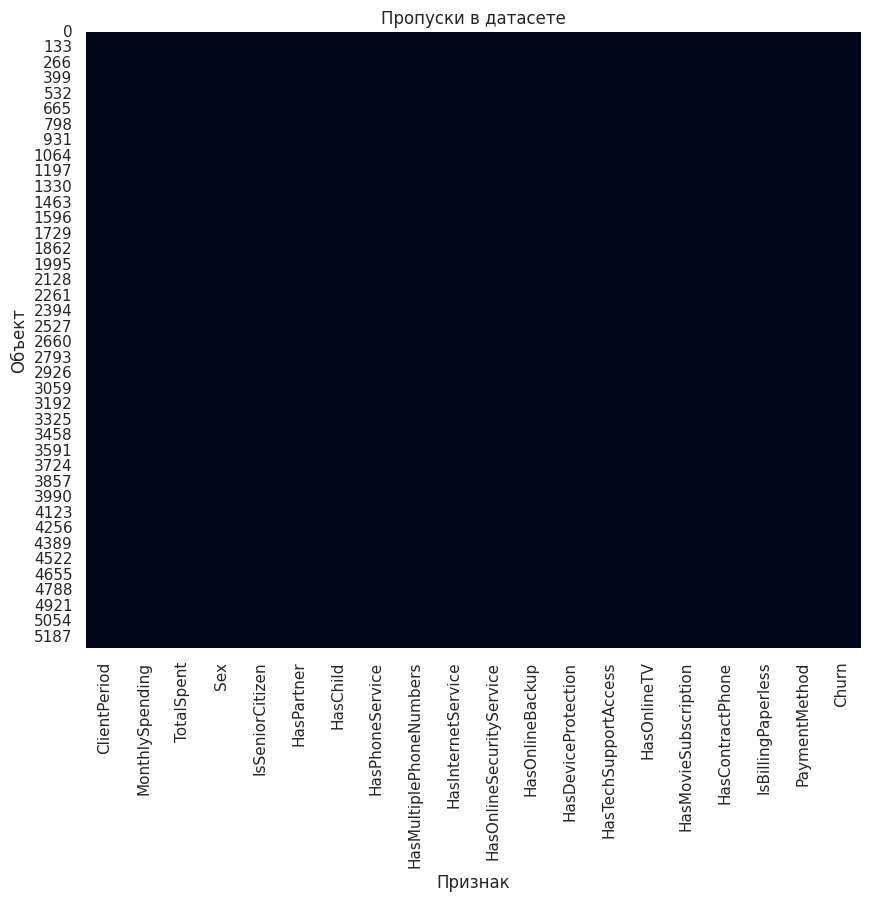

Кол-во пропусков в каждом признаке:
ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64


In [427]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_train.isnull(), cbar=False)
plt.title('Пропуски в датасете')
plt.xlabel('Признак')
plt.ylabel('Объект')
plt.show()

print('Кол-во пропусков в каждом признаке:')
print(data_train.isnull().sum())

Heatmap и количество пропусков говорят, что нет пропусков в виде NaN.

In [428]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

for column in categorical_columns:
    print('-'*5, column, '-'*5)
    print(data_train[column].value_counts())
    print('\n')

----- TotalSpent -----
           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: TotalSpent, Length: 4978, dtype: int64


----- Sex -----
Male      2655
Female    2627
Name: Sex, dtype: int64


----- HasPartner -----
No     2705
Yes    2577
Name: HasPartner, dtype: int64


----- HasChild -----
No     3676
Yes    1606
Name: HasChild, dtype: int64


----- HasPhoneService -----
Yes    4761
No      521
Name: HasPhoneService, dtype: int64


----- HasMultiplePhoneNumbers -----
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64


----- HasInternetService -----
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64


----- HasOnlineSecurityService -----
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64


----- HasOnl

У TotalSpent есть значение <b>пробела</b> вместо числа, поэтому и получился object, исправим это

In [429]:
data_train.TotalSpent.replace(' ', np.nan, inplace=True)
data_train.TotalSpent = data_train.TotalSpent.astype('float64')
data_train = data_train.dropna()

Теперь пропусков в обучающем датасете нет.

<br>
<b>Посмотрим как распределены значения числовых признаков</b>
<br><br>

In [430]:
numerical_columns = [col for col in data_train
                     if data_train[col].dtypes in ['int64', 'float64']]

In [431]:
def get_hist(name_feature: str, size1: int, size2: int) -> None:
    """Фукнция строит hist график по имени признака"""
    fig, ax = plt.subplots(figsize=(size1, size2))
    ax.set_title(name_feature)
    sns.set_theme(style='whitegrid', palette='pastel')
    sns.countplot(data=data_train, x=data_train[name_feature], hue='Churn')

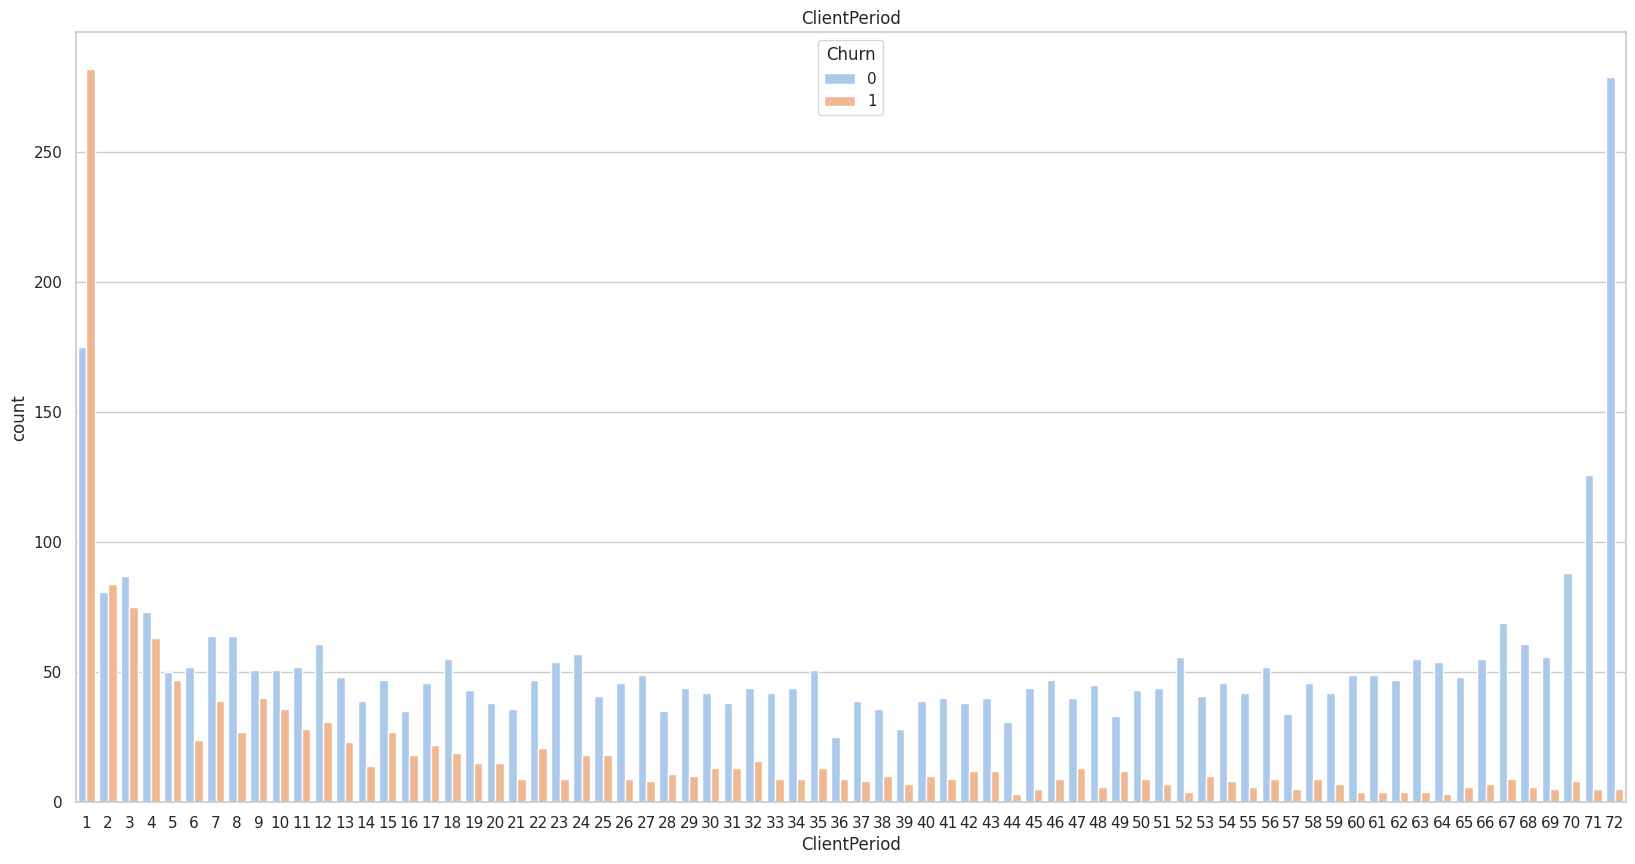

In [432]:
get_hist(name_feature='ClientPeriod', size1=20, size2=10)

In [433]:
first_one = data_train.loc[(data_train["ClientPeriod"] == 1) & (data_train['Churn'] == 1)].shape[0]
first_zero = data_train.loc[(data_train["ClientPeriod"] == 1) & (data_train['Churn'] == 0)].shape[0]

print(f'Отказ в первый день: {first_one}')
print(f'Соглашение в первый день: {first_zero}')

Отказ в первый день: 282
Соглашение в первый день: 175


На графике видно, что большинство людей уходят в первые дни пользования и это нормально. Человек устанавливает приложение и решает оставить его или нет.<br>
После примерно 15 дней использования шанс, что клиент откажется от услуг падает. <br>
В первый день вероятность отказа клиента максимальная.<br>

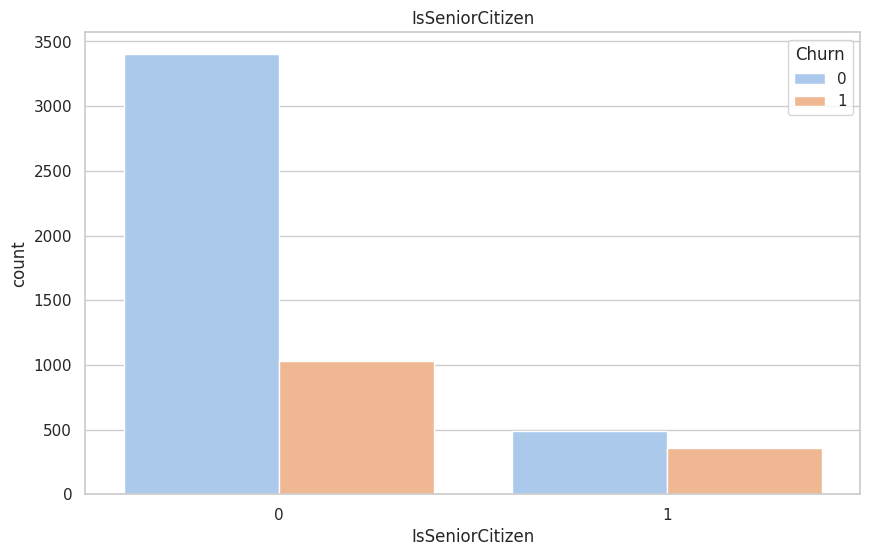

In [434]:
get_hist(name_feature='IsSeniorCitizen', size1=10, size2=6)

Пожилых людей гораздо меньше, чем молодых - с этим тоже все ок.

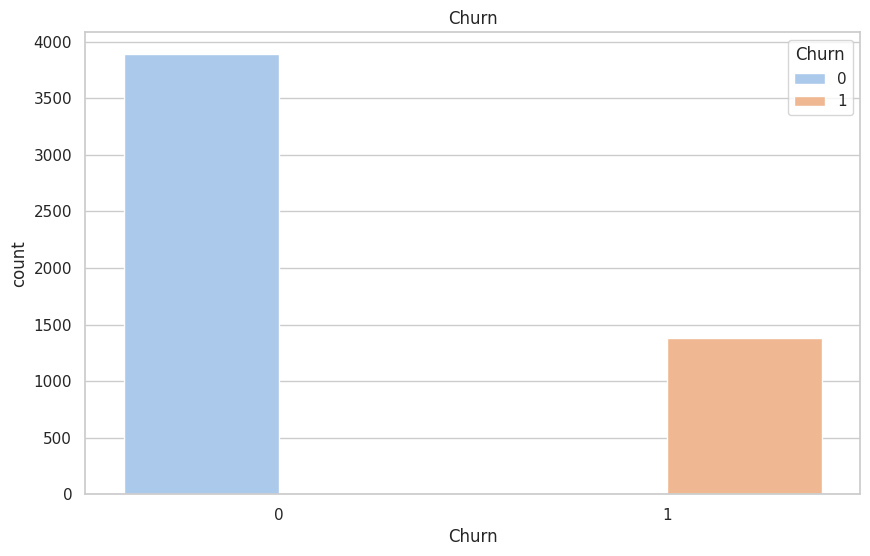

In [435]:
get_hist(name_feature='Churn', size1=10, size2=6)

In [436]:
churn_zero = data_train[data_train.Churn == 0].shape[0]
churn_one = data_train[data_train.Churn == 1].shape[0]
print(f'Класс 0: {churn_zero}')
print(f'Класс 1: {churn_one}')
print(f'Процент класса 1: {round(churn_one/data_train.shape[0] * 100)}%')

Класс 0: 3889
Класс 1: 1384
Процент класса 1: 26%


Один из главных графиков - <b>распределение целевой переменной</b>.<br>
Класс 0 превосходит в количестве класс 1, разница = 2505. <b>Целевая переменная несбалансированная</b>.<br>
Проблему с балансом мы решим на этапе предобработки данных.
<br><br>
<b>Вывод:</b> 26% клиентов отказываются от услуг компании, при этом большинство в первый же день, такой показатель можно считать плохим. Большинство клиентов - "не пожилые люди".

<br>
<b>Посмотрим как распределены значения категориальных признаков.</b>
<br><br>

In [437]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

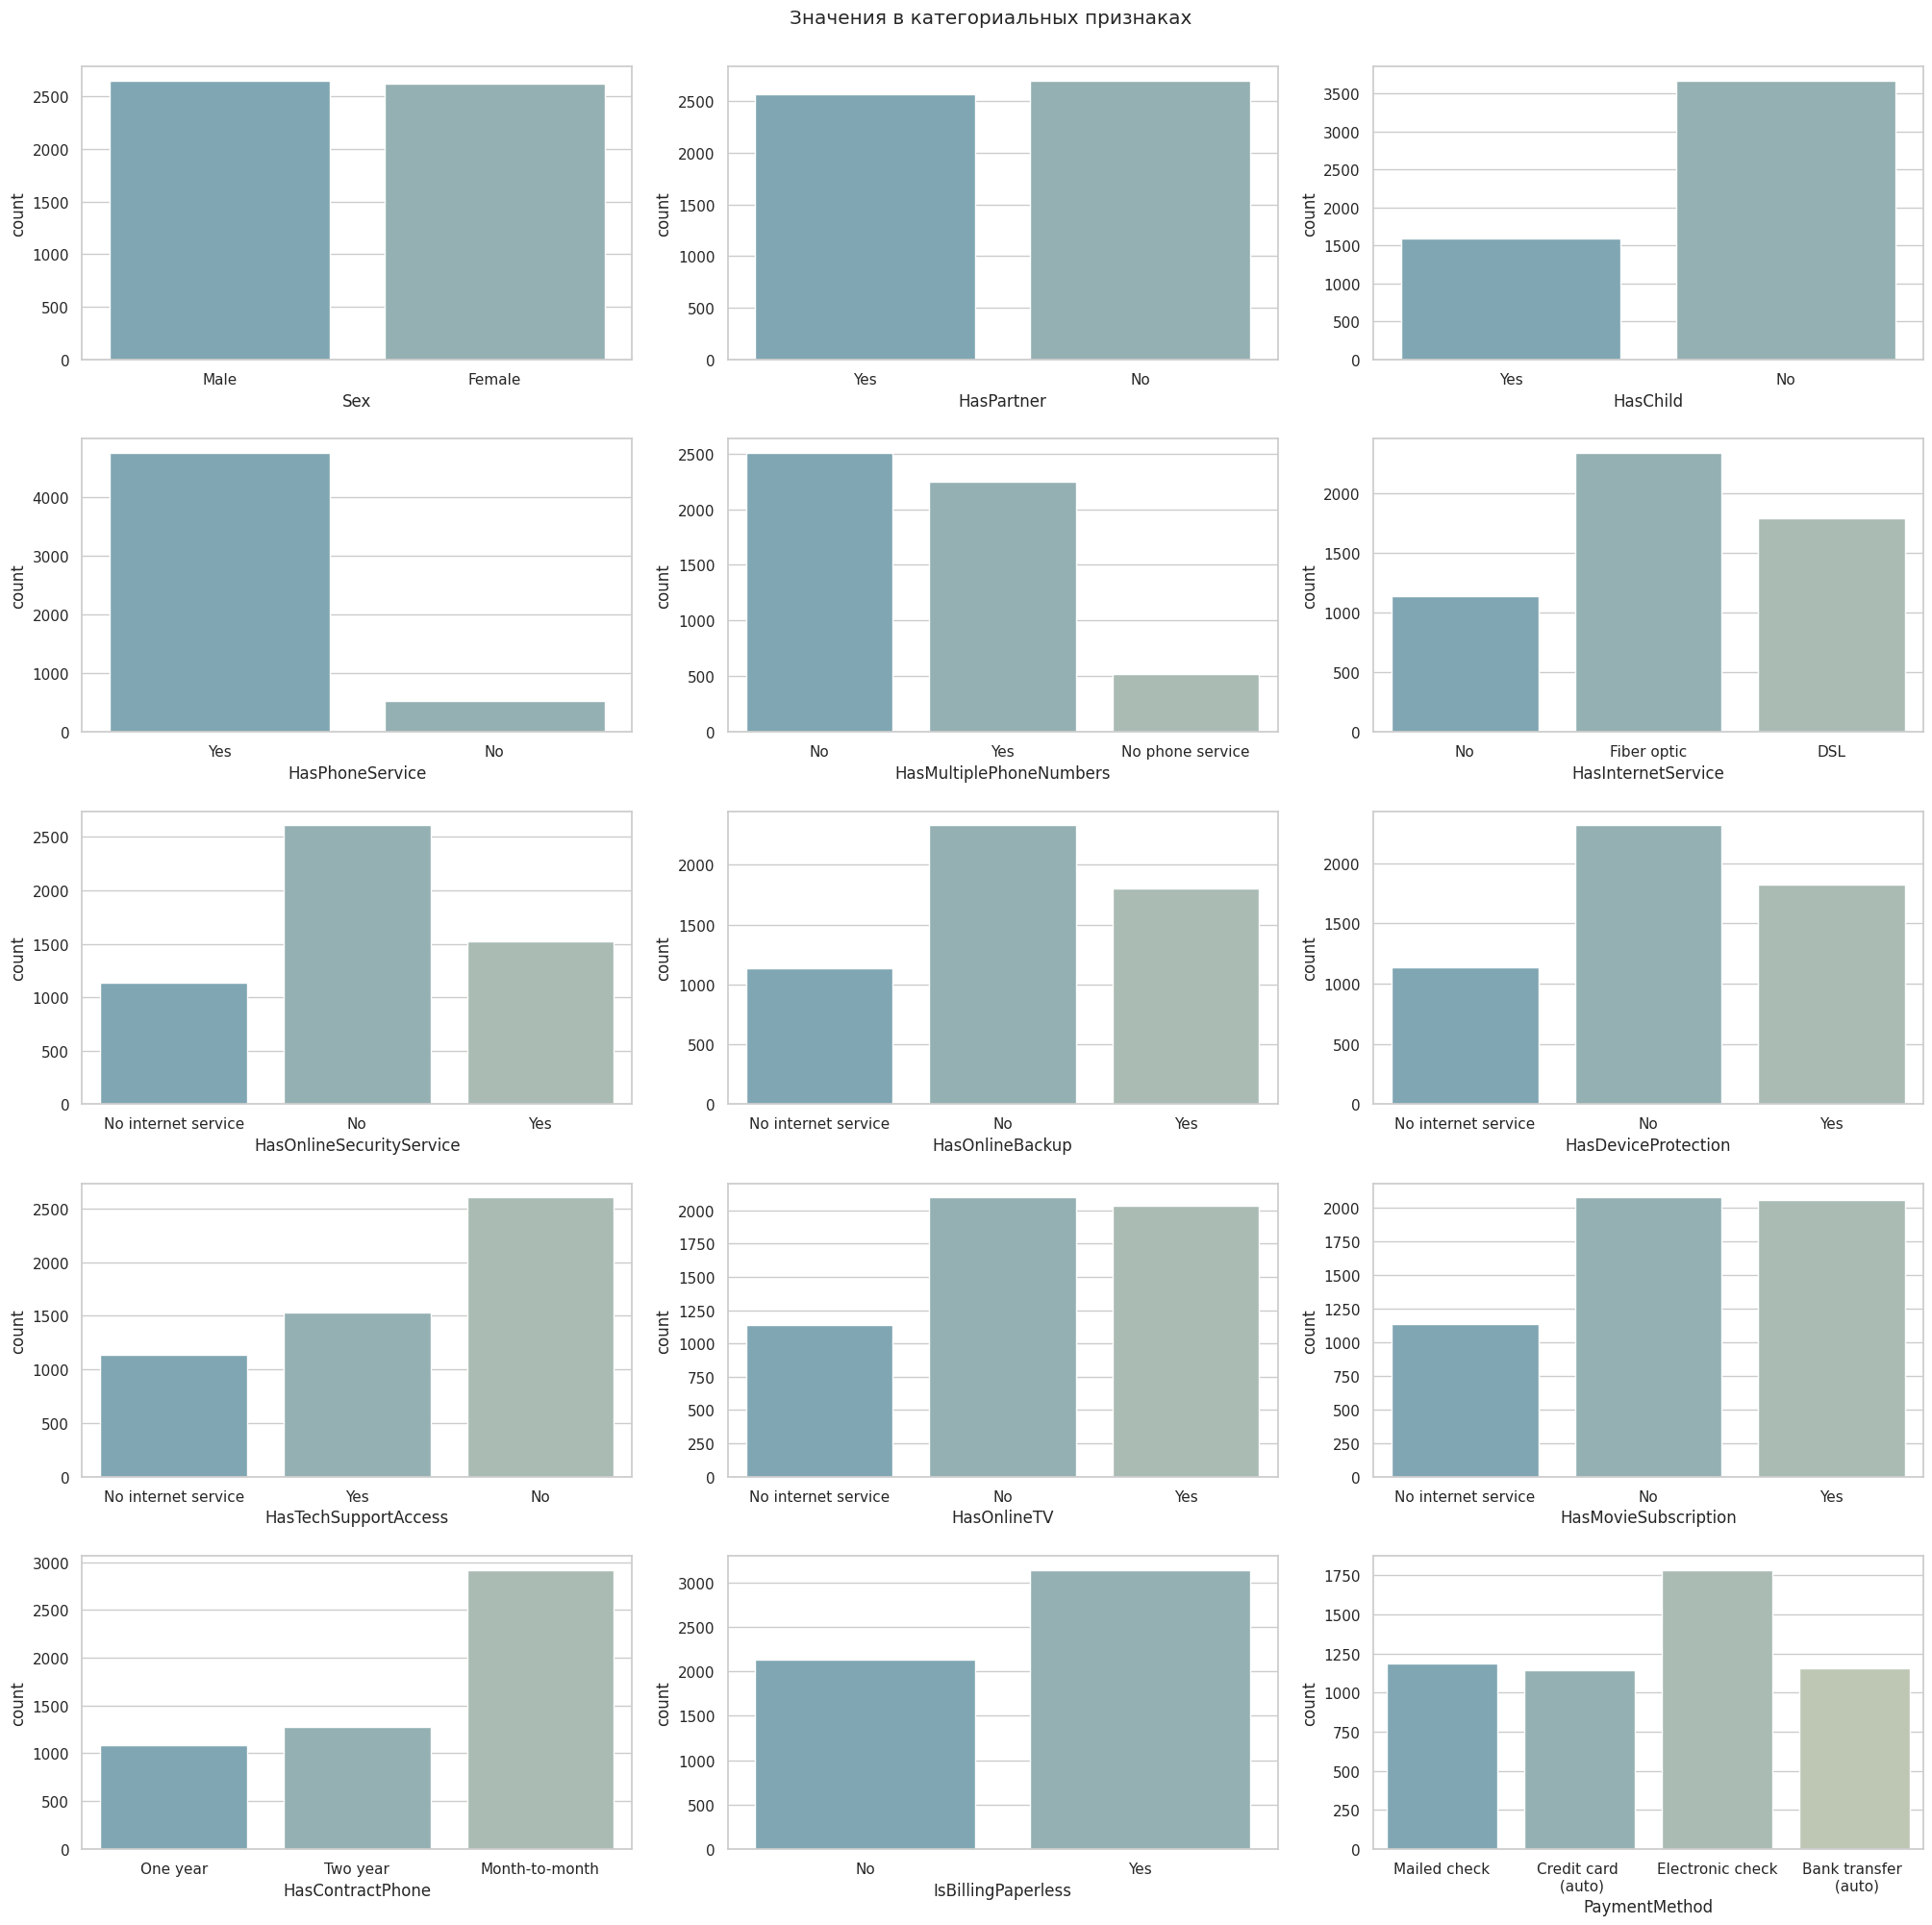

In [438]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = ax.flatten()
fig.suptitle('Значения в категориальных признаках')
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.95)

sns.set_theme(style='whitegrid', palette="blend:#7AB,#EDA")
labels = ['Mailed check', 'Credit card \n (auto)', 'Electronic check', 'Bank transfer \n (auto)'] # labes для PaymentMethod
for i in range(len(categorical_columns)):
    sns.countplot(ax=ax[i], x=data_train[categorical_columns[i]])
    ax[14].set_xticklabels(labels)

In [439]:
data_train['HasContractPhone'].unique(), data_train['HasContractPhone'].value_counts()

(array(['One year', 'Two year', 'Month-to-month'], dtype=object),
 Month-to-month    2920
 Two year          1272
 One year          1081
 Name: HasContractPhone, dtype: int64)

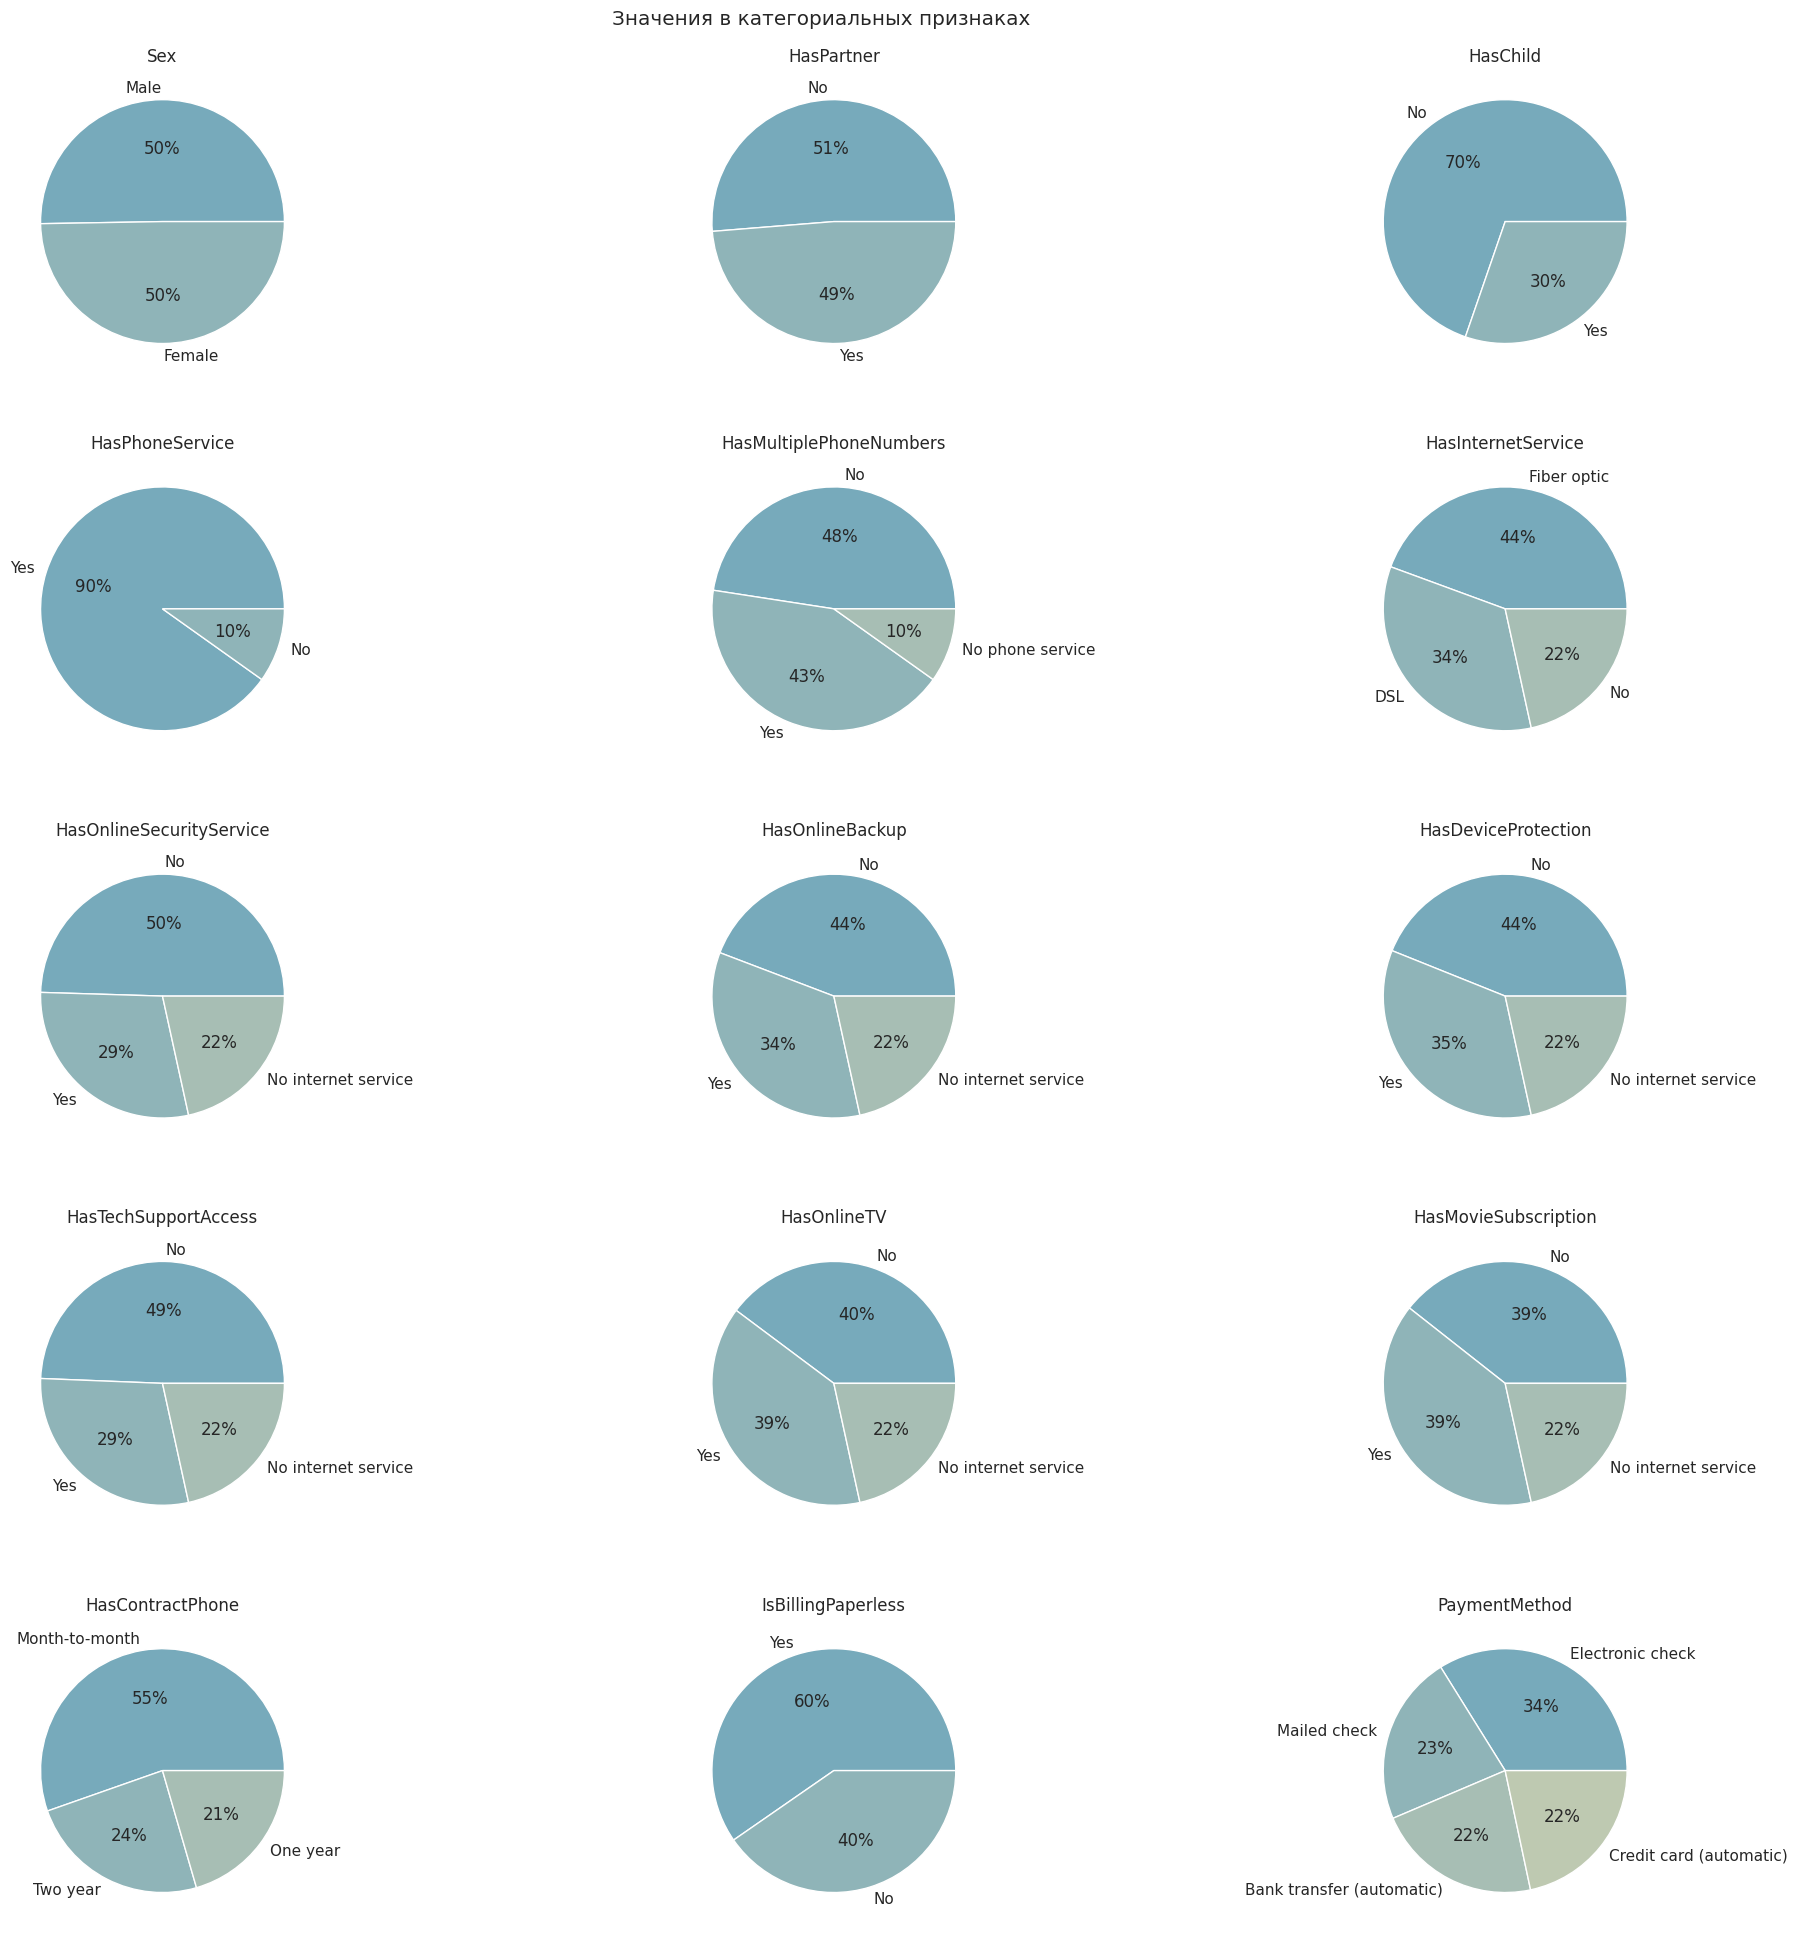

In [440]:
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
ax = ax.flatten()
fig.suptitle('Значения в категориальных признаках')
fig.tight_layout(h_pad=3, w_pad=3)
plt.subplots_adjust(top=0.95)

sns.set_theme(style='whitegrid', palette="flare")
for i in range(len(categorical_columns)):
    data = data_train[categorical_columns[i]]
    ax[i].pie(x=data.value_counts(), labels=data.value_counts().index, autopct='%.0f%%')
    ax[i].set_title(categorical_columns[i])

<br>
<br>Сделаем попытку в нахождении выбросов</br>
<br>

In [441]:
data_train.describe()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
count,5273.000000,5273.000000,5273.000000,5273.000000,5273.000000
mean,32.452304,64.956770,2291.390461,0.159681,0.262469
std,24.534723,30.177911,2269.014233,0.366345,0.440018
min,1.000000,18.250000,18.800000,0.000000,0.000000
25%,9.000000,35.500000,401.100000,0.000000,0.000000
50%,29.000000,70.450000,1410.250000,0.000000,0.000000
75%,55.000000,90.050000,3807.350000,0.000000,1.000000
max,72.000000,118.750000,8684.800000,1.000000,1.000000


Стандратное отклонение у всех довольно большое, но TotalSpent самый подозрительный, во-первых, из-за того же std, во-вторых, из-за разницы в процентилях.<br>

<br>
<b>Проведем двумерный анализ и ,возможно, там найдем выборсы</b>
<br><br>

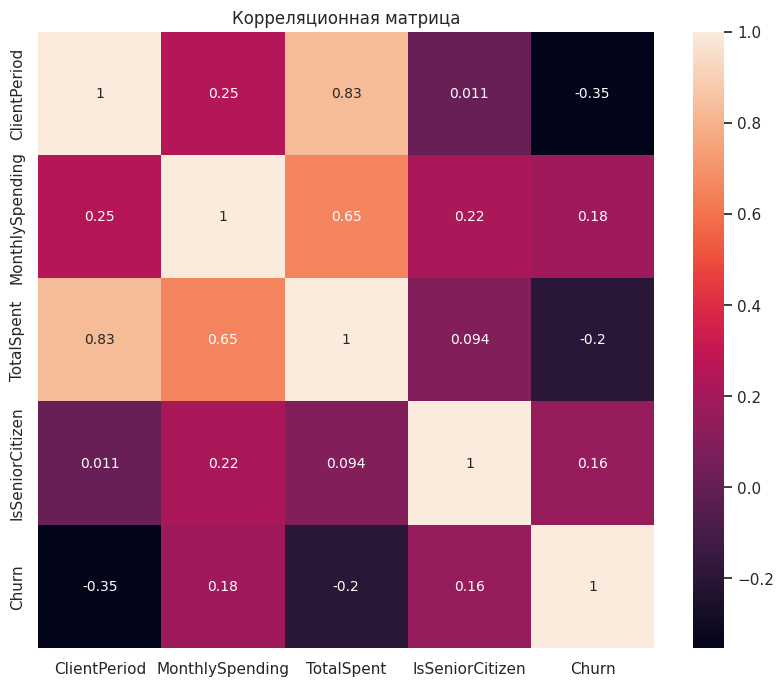

In [442]:
def corrmat(data: pd.DataFrame) -> None:
    """
       Построение корреляционной матрицы
       с коэффициентом корреляции Пирсона.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(data.corr(), annot=True, square=True, annot_kws={'size': 10}).set_title('Корреляционная матрица')
    plt.show()
    
corrmat(data_train)

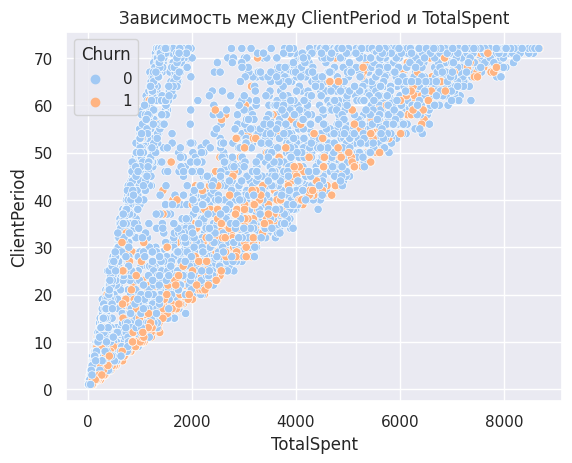

In [443]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x='TotalSpent', y='ClientPeriod', data=data_train, hue='Churn').set_title('Зависимость между ClientPeriod и TotalSpent')
plt.show()

График показывает:
 - Какое минимальное кол-во денег можно потратить за каждый день подписки
 - Какое максимальное кол-во денег можно потратить за каждый день подписки

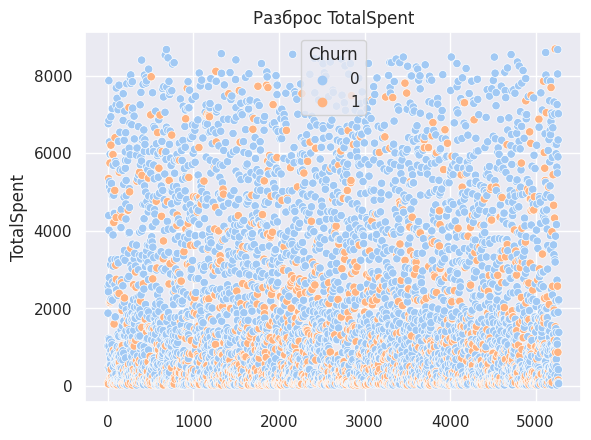

In [444]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x=range(data_train.TotalSpent.shape[0]), y='TotalSpent', data=data_train, hue='Churn').set_title('Разброс TotalSpent')
plt.show()

Выбросов не наблюдается

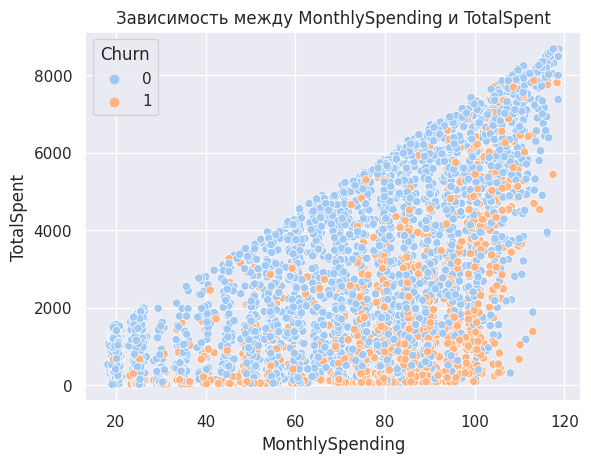

In [445]:
sns.set_theme(style='darkgrid', palette='pastel')
sns.scatterplot(x='MonthlySpending', y='TotalSpent', data=data_train, hue='Churn').set_title('Зависимость между MonthlySpending и TotalSpent')
plt.show()

<br>
<font size=6>Эпизод ⅠⅠ</font><br>
<br>
<font size=5>Линейные модели</font>
<hr>

<br>
<b>Предобработка данных</b>
<br><br>

In [446]:
data_train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


<br>
<b>Добавим новые признаки</b><br>
<br>

In [469]:
data_train['probation'] = (data_train.ClientPeriod > 5).map(lambda x: int(x))
data_train

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,probation
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,0,No,Mailed check,0,1
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,1,No,Credit card (automatic),0,1
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,...,No,No,Yes,No,No,2,Yes,Electronic check,1,0
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,...,No,Yes,No,No,No,2,No,Mailed check,0,1
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Yes,1,No,Credit card (automatic),0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5277,3,30.40,82.15,Male,0,No,No,No,No phone service,DSL,...,No,No,Yes,No,No,2,No,Electronic check,0,0
5278,50,44.45,2188.45,Male,0,Yes,No,No,No phone service,DSL,...,No,No,Yes,Yes,No,0,Yes,Bank transfer (automatic),0,1
5279,1,55.05,55.05,Male,0,No,No,Yes,No,DSL,...,No,Yes,Yes,No,No,2,No,Mailed check,0,0
5280,29,76.00,2215.25,Female,0,No,No,Yes,Yes,Fiber optic,...,No,No,No,No,No,2,Yes,Credit card (automatic),0,1


Есть подозрения, что HasContractPhone, который имеет значения времени (Month-to-month, One year, Two year), должен неплохо так влиять на решение отказываться ли пользователю от услуг.<br>
Поэтому попробуем перевести HasContractPhone в числовой вид, а после посмотрим на корреляционную матрицу.

In [447]:
data_train.HasContractPhone = pd.factorize(data_train.HasContractPhone)[0] # кодириуем значения из HasContractPhone

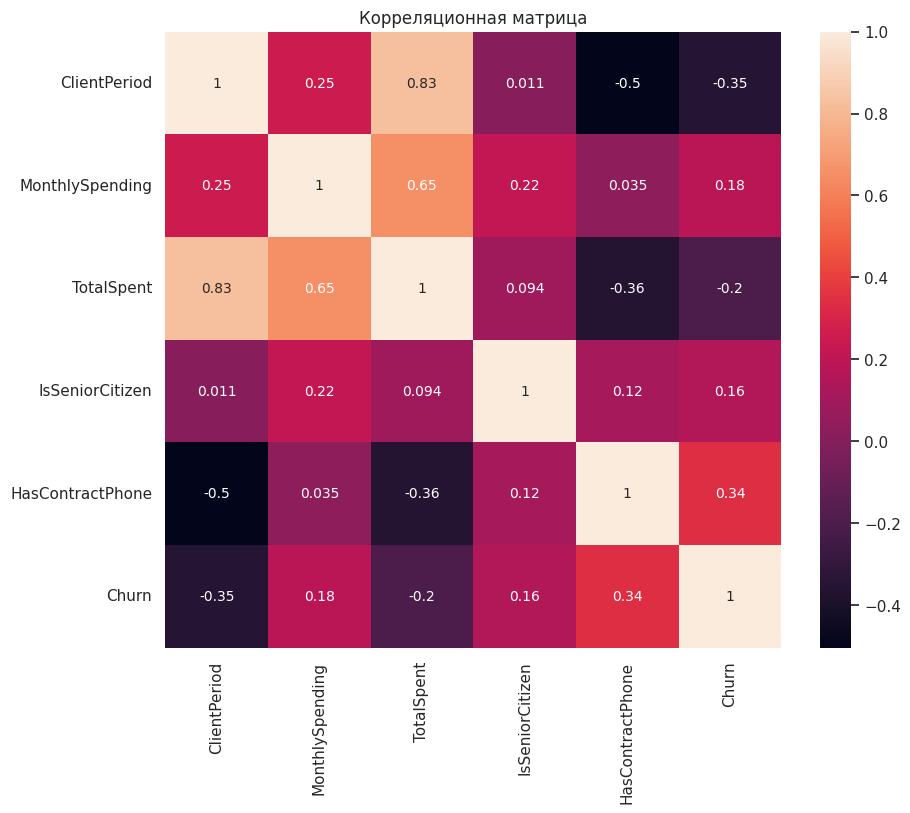

In [448]:
corrmat(data=data_train)

Коэффициент корреляции между HasControlPhone и таргетом Churn = 0.34, что относительно других показателей очень даже хорошо.

<br>
Признак <b>HasContractPhone</b> теперь не является object, поэтому соберем категориальные признаки еще раз<br>
<br>

In [449]:
categorical_columns = [col for col in data_train
                       if data_train[col].dtypes == 'object']

<br>
Остальныe <i>категориальные признаки</i> будем кодировать в два этапа:<br>
<br>
 1) LabelEncoder - превращаем строчки в числа<br>
 2) OneHotEncoder - превращаем полученные числа в one-hot вектора. Этот этап совместим с нормировко числовых признаков<br>
<br>

1) LabelEncoder.<br>

In [450]:
labelencoder = LabelEncoder()

def get_label_encoder(col: pd.Series) -> pd.Series:
    """
    :col param: принимает признак из датасета
    :return : возвращает закодированную серию,
              если входная была категориальной
    """
    if col.name in categorical_columns:
        return labelencoder.fit_transform(col)
    else:
        return col

In [451]:
data_label_encoder = data_train.apply(get_label_encoder) # кодируем категориальные признаки

2) OneHotEncoder и StandardScaler

     numerical_columns = ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen', 'Churn'] 
Избавимся от <b>'IsSeniorCitizen'</b> и <b>'Churn'</b>



In [452]:
numerical_columns = numerical_columns[:-2]

In [453]:
# предобработка числовых признаков
numerical_transformer = StandardScaler()

# предобработка категориальных признаков
categorical_transformer = OneHotEncoder()

# предобработка для категориальных и числовых признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

<br>
<b>Объявление модели.</b>
<br><br>

In [454]:
model = LogisticRegression()

In [455]:
model_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ]
)

In [456]:
y = data_train.Churn
X = data_train.drop('Churn', axis=1)

<br>
<b>Поиск параметров для логистической регрессии</b>
<br><br>

In [457]:
%%time
logreg_params = {
    'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
    'model__max_iter': [50, 100, 300, 500]
}
    

logreg_search = GridSearchCV(model_pipeline,
                             param_grid=logreg_params,
                             cv=5,
                             scoring='roc_auc')

logreg_search.fit(X, y)

CPU times: user 28.5 s, sys: 17.8 s, total: 46.3 s
Wall time: 12.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'HasPartner',
                                                                          'HasChild',
                                                                          'HasPhoneService',
                                                                          'HasMultiplePhoneNumbers',
                                                                          'HasInternetService',
                                                                          'HasOnlineSecurityService',
                                                                          'HasOnlineBackup',
                                                                          'HasDeviceProtection',
                                                                          'HasTechSupportAccess',
                                                                          'HasOnlineTV',
                                                                          'HasMovieSubscription',
                                                                          'IsBillingPaperless',
                                                                          'PaymentMethod'])])),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [100, 10, 1, 0.1, 0.01, 0.001],
                         'model__max_iter': [50, 100, 300, 500]},
             scoring='roc_auc')

Лучшие параметры модели

In [458]:
print(logreg_search.best_params_)
print(logreg_search.best_score_)
print(logreg_search.best_estimator_)

{'model__C': 100, 'model__max_iter': 100}
0.8376585491782123
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'HasPartner',
                                                   'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                

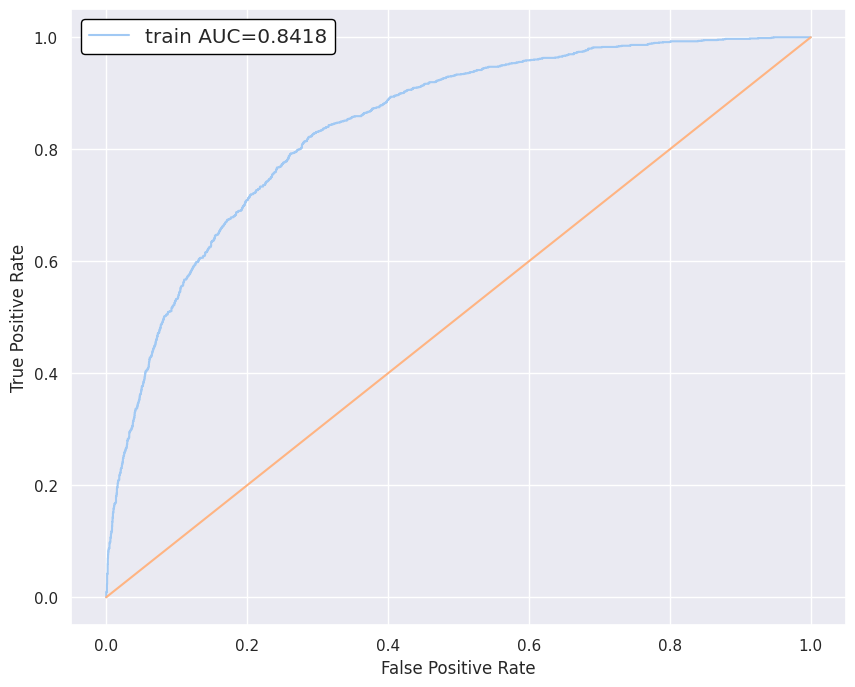

In [459]:
y_train_predicted = logreg_search.predict_proba(X)[:, 1]

train_auc = roc_auc_score(y, y_train_predicted)

plt.figure(figsize=(10,8))
plt.plot(*roc_curve(y, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

TO DO LIST:
 - Добавить новые фичи (из своих знаний и xi*xj)
 - Решить проблему дисбаланса
 - Проверить как каждый пункт влияет на предсказания
 - Применить RandomForest без нормировки данных
 - Применить стекинг
 - Применить бустинг: XGBOOST, CATBOOST